In [1]:
import json
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
with open('esp32-4a657-default-rtdb-export.json', 'r', encoding='utf-8') as archivo:
    datos = json.load(archivo)

print(datos)

{'Aceite': {'621': 6.175, '654': 6.652, '687': 7.34, '720': 8.124, '753': 8.993, '786': 9.234, '819': 8.77, '852': 7.955, '885': 7.418, '918': 6.965, '951': 6.845, '984': 7.008, '1017': 7.364, '1050': 8.021, '1083': 8.595, '1116': 8.981, '1149': 8.999, '1182': 8.607, '1215': 8.082, '1248': 7.852, '1281': 7.472, '1314': 7.448, '1347': 7.593, '1380': 7.961, '1413': 8.19, '1446': 8.583, '1479': 8.721, '1512': 8.564, '1545': 8.208, '1578': 8.009, '1611': 7.696, '1644': 7.599, '1677': 7.593, '1710': 7.81, '1743': 8.033, '1776': 8.293, '1809': 8.426, '1842': 8.414, '1875': 8.221, '1908': 8.003, '1941': 7.834, '1974': 7.671, '2007': 7.659, '2040': 7.756, '2073': 7.967, '2106': 8.13, '2139': 8.293, '2172': 8.365, '2205': 8.293, '2238': 8.142, '2271': 8.009, '2304': 7.852, '2337': 7.846, '2370': 7.895, '2403': 8.009, '2436': 8.172, '2469': 8.251, '2502': 8.263, '2535': 8.275, '2568': 8.172, '2601': 8.058, '2634': 7.961, '2667': 7.907, '2700': 7.955, '2733': 7.997, '2766': 8.082, '2799': 8.142, 

In [3]:
g = 9.7761 #m/s^2. Valor extraído de: https://www.mavincolombia.com/uploads/1/7/4/0/1740594/listado_de_ciudades_y_valor_de_gravedad_.pdf

# **Masa en el aire**

Ecuación de movimiento:

$$\frac{d^2y}{dt^2}+\frac{k}{m}y+ \left( g - \frac{k}{m}l  \right), $$

de dónde $l$ es la posición de equilibrio. La solución de esta ecuación diferencial es:

$$ y = C_1 cos \left( \sqrt{\frac{k}{m}} t \right)+C_2 sin \left( \sqrt{\frac{k}{m}} t \right) + l - \frac{mg}{k}.$$

Suponiendo que en el tiempo $t=0$ se alcanza la amplitud máxima $y_0$, la velocidad $\frac{dy}{dt}$ se hace nula. Teniendo esto en cuenta, al reemplazar estas condiciones iniciales en la solución anterior, se tiene que $C_1=y_0-l+\frac{mg}{k}$ y $C_2=0$, es decir:

$$ y = \left( y_0-l+\frac{mg}{k} \right) cos \left( \sqrt{\frac{k}{m}} t \right) + l - \frac{mg}{k}.$$

El objetivo de suponer estas condiciones iniciales es para no tener que pedirle `curve_fit` que haga más trabajo, y se centre solamente en hallar $k$.

**Datos:**

In [4]:
m_a = 99 #La masa del objeto en gramos.

#Acá los pongo a que empiecen en el primer valor que coincide con la amplitud máxima, por eso no le resto los 621 ms del primer término, sino los 687 del
#tercero.

t_a = (np.array([float(i) for i in list(datos["Aire"].keys())])[2:]-687)/1000  #s
y_a =  np.array(list(datos["Aire"].values()))[2:] #cms

l_a = np.mean(y_a)  #posición de equilibrio en cms

**Ajuste:**

In [5]:
def air(t,k):
    return  (y_a[0]-l_a+(m_a*(g/k))) * np.cos(((k/m_a)**0.5) * t)  + l_a - ((m_a * g) / k)

In [6]:
# estimación inicial para k
p0 = [10000.0]

# ajuste
parametros_opt, cov = curve_fit(air, t_a, y_a, p0=p0)

k_a = parametros_opt[0]
k_a_err = np.sqrt(np.diag(cov))[0]

print(f"k = ({k_a:.2f} ± {k_a_err:.2f}) g/s^2")

k = (10008.26 ± 4.08) g/s^2


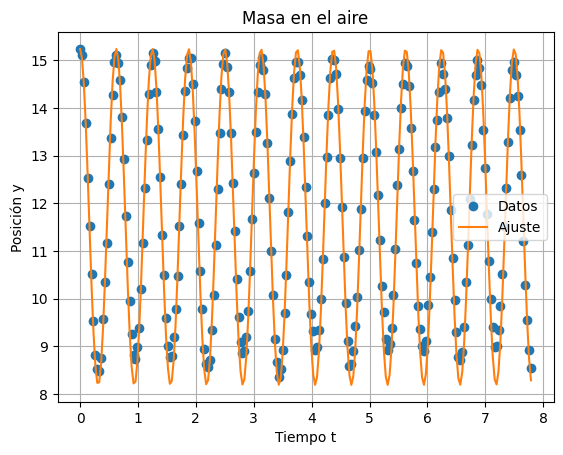

In [7]:
# curva ajustada
y_fit = air(t_a, k_a)

plt.plot(t_a, y_a, 'o', label='Datos')
plt.plot(t_a, y_fit, '-', label='Ajuste')
plt.title("Masa en el aire")
plt.xlabel('Tiempo t')
plt.ylabel('Posición y')
plt.legend()
plt.grid(True)
plt.show()

# **Masa en agua y aceite**

Ecuación de movimiento:

$$\frac{d^2y}{dt^2}+\frac{C}{m} \frac{dy}{dt}+\frac{k}{m}y+ \left( g - \frac{k}{m}l  \right), $$

la solución de esta ecuación diferencial es:

$$ y = e^{-\frac{C}{2m}t} \left[ C_1 cos \left(  \omega   t \right)+C_2 sin \left(  \omega   t \right)\right] + l - \frac{mg}{k} ,$$

de dónde 

$$\omega = \sqrt{\frac{k}{m}-{\left( \frac{C}{2m} \right)}^2}.$$

De manera análoga al caso anterior, asumiendo que en $t=0$ tenemos una amplitud máxima $y_0$, la velocidad aquí sería nula. Así pues $C_1 = \left( y_0-l+\frac{mg}{k} \right)$ y $C_2=\frac{C}{2m \omega}\left( y_0-l+\frac{mg}{k} \right)$. No se utilizó la forma $y(t)=A e^{-\frac{C}{2m}t}cos \left( \omega t -\phi \right)+l - \frac{mg}{k}$ porque $\phi = {tan}^{-1} \left( \frac{C}{2m \omega} \right)$ y después hallar $C$ se vuelve un complique. Así pues, la solución queda:

$$y(t) = e^{-\frac{C}{2m}t} \left[ \left( y_0 - l + \frac{mg}{k} \right) \left( cos \omega t + \frac{C}{2m \omega} sin \omega t \right) \right] + l - \frac{mg}{k}$$

In [8]:
m_wo = 32.46 #La masa del objeto en gramos.

### **Agua:**

In [9]:
#Acá los pongo a que empiecen en el primer valor que coincide con la amplitud máxima. En este caso coincide con el valor i=0.
#Tomé el segundo conjunto de datos del Agua porque lo medí con más cuidado. 

t_w = (np.array([float(i) for i in list(datos["Agua2"].keys())])-621)/1000  #s
y_w =  np.array(list(datos["Agua2"].values())) #cms

l_w = np.mean(y_w)  #posición de equilibrio en cms

**Ajuste:**

In [10]:
def water(t,k,C):

    w = np.sqrt((k/m_wo)-((C/(2.0*m_wo))**2.0))

    return  np.exp(-(C/(2*m_wo))*t)*( (y_w[0]-l_w + ((m_wo*g)/k))*(np.cos(w*t)+(C/(2*m_wo*w))*np.sin(w*t))) + l_w - ((m_wo*g)/k)

In [11]:
# estimación inicial 
p02 = [10000, 10]


bounds = (
    [1000,0],     # límites inferiores
    [100000,100]   # límites superiores
)

# ajuste
parametros_opt2, cov2 = curve_fit(water, t_w, y_w, p0=p02,bounds = bounds)

k_w, C_w = parametros_opt2
k_w_err, C_w_err = np.sqrt(np.diag(cov2))

print(f"k = ({k_w:.2f} ± {k_w_err:.2f}) g/s^2, C = ({C_w:.2f} ± {C_w_err:.2f}) g/s")

k = (11598.65 ± 10.56) g/s^2, C = (24.54 ± 0.56) g/s


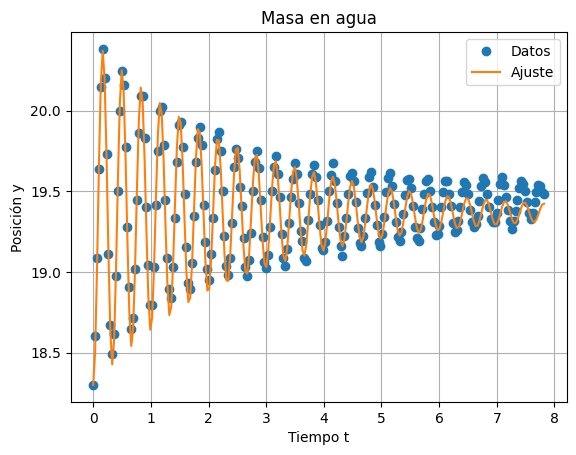

In [12]:
# curva ajustada
y_fit = water(t_w, k_w, C_w)

plt.plot(t_w, y_w, 'o', label='Datos')
plt.plot(t_w, y_fit, '-', label='Ajuste')
plt.title("Masa en agua")
plt.xlabel('Tiempo t')
plt.ylabel('Posición y')
plt.legend()
plt.grid(True)
plt.show()

### **Aceite:**

In [ ]:
#Acá los pongo a que empiecen en el primer valor que coincide con la amplitud máxima. En este caso coincide con el valor i=0. 

t_o = (np.array([float(i) for i in list(datos["Aceite"].keys())])-621)/1000  #s
y_o =  np.array(list(datos["Aceite"].values())) #cms

l_o = np.mean(y_o)  #posición de equilibrio en cms

**Ajuste:**

In [14]:
def oil(t,k,C):

    w = np.sqrt((k/m_wo)-((C/(2.0*m_wo))**2.0))

    return  np.exp(-(C/(2*m_wo))*t)*( (y_o[0]-l_o + ((m_wo*g)/k))*(np.cos(w*t)+(C/(2*m_wo*w))*np.sin(w*t))) + l_o - ((m_wo*g)/k)

In [15]:
# estimación inicial 
p03 = [10000, 10]


bounds = (
    [100,0],     # límites inferiores
    [100000,1000]   # límites superiores
)

# ajuste
parametros_opt3, cov3 = curve_fit(oil, t_o, y_o, p0=p03,bounds = bounds)

k_o, C_o = parametros_opt3
k_o_err, C_o_err = np.sqrt(np.diag(cov3))

print(f"k = ({k_o:.2f} ± {k_o_err:.2f}) g/s^2, C = ({C_o:.2f} ± {C_o_err:.2f}) g/s")

k = (11092.25 ± 58.60) g/s^2, C = (86.48 ± 3.17) g/s


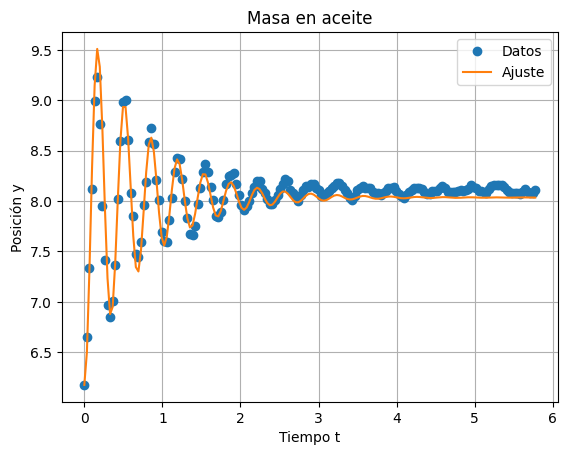

In [16]:
# curva ajustada
y_fit3 = oil(t_o,k_o,C_o)

plt.plot(t_o, y_o, 'o', label='Datos')
plt.plot(t_o, y_fit3, '-', label='Ajuste')
plt.title("Masa en aceite")
plt.xlabel('Tiempo t')
plt.ylabel('Posición y')
plt.legend()
plt.grid(True)
plt.show()